In [ ]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [ ]:
def read_masks(filepath, img_h, img_w):
    # read label file:
    with open(filepath, 'r') as lbl_file:
        lines = lbl_file.readlines()
    # label lines --> list of points:
    all_points = [
        [float(x) for x in line[2:].split(' ')]
        for line in lines
    ]
    # list of [0,1] points --> array of [0, img_size] points:
    poly_masks = [
        np.array(shape).reshape(-1, 2) * np.array([[img_h, img_w]])
        for shape in all_points
    ]
    # make binary mask:
    color = (1, 1, 1)
    binary_mask = np.zeros((img_h, img_w))
    cv2.fillPoly(binary_mask, [m.astype(int) for m in poly_masks], color)
    return poly_masks, binary_mask.astype(int)


def parse_img_label(img_p, lbl_p):
    image = cv2.cvtColor(cv2.imread(img_p), cv2.COLOR_BGR2RGB)
    img_h, img_w, img_ch = image.shape
    if lbl_p.split('.') == 'txt':
        poly_masks, binary_mask = read_masks(lbl_p, img_h, img_w)
    else:
        poly_masks = None
        binary_mask = cv2.cvtColor(cv2.imread(lbl_p), cv2.COLOR_BGR2GRAY)
        if binary_mask.max() > 1:
            binary_mask = (binary_mask / 255).round().astype(int)
    return image, poly_masks, binary_mask

In [ ]:
class UNetDataSet(Dataset):
    in_channels = 3
    out_channels = 1

    def __init__(self, img_dir, mask_dir, image_size=256):
        self.images = [os.path.join(img_dir, x) for x in os.listdir(img_dir)]
        self.masks = [os.path.join(mask_dir, x) for x in os.listdir(mask_dir)]
        self.image_size = image_size

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # paths:
        img_p = self.images[idx]
        mask_p = self.masks[idx]
        # open:
        image, _, binary_mask = parse_img_label(img_p, mask_p)
        image = Image.fromarray(image)
        mask = Image.fromarray(binary_mask.astype(float))
        # tensors:
        image_tensor = self.transform(image)
        mask_tensor = torch.where(self.transform(mask) > 0, 1, 0).float()
        return image_tensor, mask_tensor

In [ ]:
class ModelTrainer:
    def __init__(self, model, optimizer, loss_function, callback=None):
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.callback = callback

        _device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = torch.device(_device_name)
        
    def train_model(self, dataloader, epochs) -> None:
        iterations = tqdm(range(epochs), desc='epoch')
        iterations.set_postfix({'train epoch loss': np.nan})
        for epoch in iterations:
            epoch_loss = self._train_epoch(dataloader)
            iterations.set_postfix({'train epoch loss': epoch_loss})
            if self.callback is not None:
                self.callback(self.model, epoch_loss)
    
    def _train_epoch(self, batch_generator) -> float:
        epoch_loss = 0
        total = 0
        for batch_x, batch_y in batch_generator:
            batch_loss = self._train_on_batch(
                batch_x.to(self.device), batch_y.to(self.device))
            epoch_loss += batch_loss*batch_x.shape[0]
            total += batch_x.shape[0]
        return epoch_loss / total

    def _train_on_batch(self, x_batch, y_batch) -> float:
        self.model.train()
        self.model.zero_grad()
        output = self.model(x_batch)
        loss = self.loss_function(output, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.cpu().item()

In [ ]:
class CallBack:
    def __init__(self, test_loader, loss_function):
        self.test_loader = test_loader
        self.loss_function = loss_function

        self.train_loss = []
        self.test_loss = []

        _device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = torch.device(_device_name)

    def __call__(self, model, train_epoch_loss):
        # calc test loss:
        test_epoch_loss = 0
        total = 0
        for batch_x, batch_y in self.test_loader:
            with torch.no_grad():
                output = model(batch_x.to(self.device))
            batch_loss = self.loss_function(output, batch_y.to(self.device))
            test_epoch_loss += batch_loss.cpu().item() * batch_x.shape[0]
            total += batch_x.shape[0]
        test_epoch_loss /= total
        # add losses:
        self.train_loss.append(train_epoch_loss)
        self.test_loss.append(test_epoch_loss)
        # print losses:
        print('-'*15)
        print(f'epoch: {len(self.test_loss)}')
        print('train:', round(train_epoch_loss, 3))
        print('test:', round(test_epoch_loss, 3))
        
    def plot_losses(self):
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(self.train_loss, label='Train loss')
        ax.plot(self.test_loss, label='Test loss')
        plt.legend()
        plt.show()

In [ ]:
def masks_tensors_iou(tens_0, tens_1):
    intersection = (tens_0 * tens_1).sum(axis=(1, 2, 3))
    union = ((tens_0 + tens_1) > 0).sum(axis=(1, 2, 3))
    return intersection / union


def eval_iou_over_dataset(data_loader, model, p=0.5, device=None):
    """Будем считать средневзвешенное IoU по изображениям."""
    
    if device is None:
        _device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
        device = torch.device(_device_name)

    model.eval()

    mean_iou = 0
    total = 0
    for batch_x, batch_y in tqdm(data_loader):
        with torch.no_grad():
            batch_pred_probs = model(batch_x.to(device))
            batch_pred = (batch_pred_probs > p).int()
        batch_iou = masks_tensors_iou(batch_pred, batch_y.to(device)).mean()
        mean_iou += batch_iou * batch_x.shape[0]
        total += batch_x.shape[0]
    return mean_iou / total

In [ ]:
def show_img_lbl(img_p, lbl_p):
    image, _, binary_mask = parse_img_label(img_p, lbl_p)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image)
    ax[0].set_title('Source Image', fontsize=15)

    ax[1].imshow(binary_mask, 'gray')
    ax[1].set_title('Segmentation Mask', fontsize=15)

    plt.show()


def plot_ds_tens(img_tens, lbl_tens):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img_tens.numpy().transpose(1, 2, 0))
    ax[0].set_title('Source Image', fontsize=15)

    ax[1].imshow(lbl_tens.squeeze().numpy(), 'gray')
    ax[1].set_title('Segmentation Mask', fontsize=15)

    plt.show()

# 1. Dataset

In [ ]:
!unzip ./final_dataset_fix.zip

In [ ]:
!ls final_dataset_fix/train/images | wc
!ls final_dataset_fix/train/labels | wc

!ls final_dataset_fix/test/images | wc
!ls final_dataset_fix/test/labels | wc

     20      20     145
     20      20     145
      7       7      48
      7       7      48


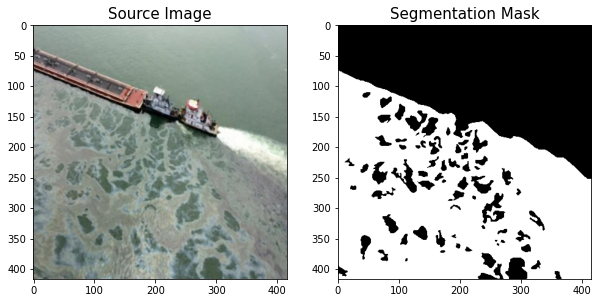

In [ ]:
img_p = 'final_dataset_fix/train/images/28.jpg'
lbl_p = 'final_dataset_fix/train/labels/28.jpg'

t = show_img_lbl(img_p, lbl_p)

In [ ]:
# train:
train_imgs_path = 'final_dataset_fix/train/images'
train_masks_path = 'final_dataset_fix/train/labels'
# train dataset:
train_dataset = UNetDataSet(train_imgs_path, train_masks_path)
print('test size:', len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)

# test paths:
test_imgs_path = 'final_dataset_fix/test/images'
test_masks_path = 'final_dataset_fix/test/labels'
# test dataset:
test_dataset = UNetDataSet(test_imgs_path, test_masks_path)
print('test size:', len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test size: 20
test size: 7


In [ ]:
img_tens, lbl_tens = train_dataset[10]

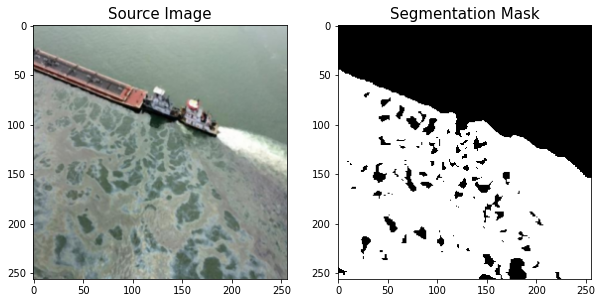

In [ ]:
plot_ds_tens(img_tens, lbl_tens)

# 2. Model

Возьмем предобученную модель и дообучим ее на наши данные.

In [ ]:
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True
)

/usr/local/lib/python3.9/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


## 2.1. Train

В качестве функии потерь возьмем `BinaryCrossEntropy`, а в качестве оптимизатора - `Adam` со стандартными параметрами.

In [ ]:
optimizer = torch.optim.Adam(unet_model.parameters())
bce_loss = torch.nn.BCELoss()

call_back = CallBack(test_loader, bce_loss)

model_trainer = ModelTrainer(
    unet_model,
    optimizer=optimizer,
    loss_function=bce_loss,
    callback=call_back
    )

Измерим среднее IoU на тестовом датасете до обучения:

In [ ]:
unet_model = unet_model.to('cuda')

In [ ]:
eval_iou_over_dataset(test_loader, unet_model)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.0001, device='cuda:0')

Обучим модель:

In [ ]:
model_trainer.train_model(train_loader, epochs=30)

Измерим качество после обучения:

In [ ]:
eval_iou_over_dataset(test_loader, unet_model)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3883, device='cuda:0')

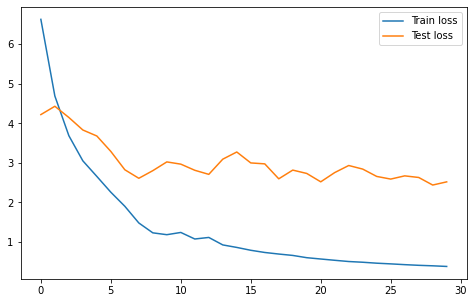

In [ ]:
call_back.plot_losses()

## 2.2. Testing

train / test datasets

In [ ]:
def plot_examples_predict(model, dataset, images_ids, save_name=None):
    rows = len(images_ids)
    cols = 3

    fig, ax = plt.subplots(rows, cols, figsize=(12, rows*3))
    ax[0, 0].set_title('Source image')
    ax[0, 1].set_title('True mask')
    ax[0, 2].set_title('Predict mask')

    for i, img_id in enumerate(images_ids):
        tens_img, tens_mask = dataset[img_id]
        model_input = tens_img.unsqueeze(0).to('cuda')
        with torch.no_grad():
            pred_mask = (model(model_input) > 0.5).float()

        ax[i, 0].imshow(tens_img.numpy().transpose(1, 2, 0))
        ax[i, 1].imshow(tens_mask.numpy().transpose(1, 2, 0), 'gray')
        ax[i, 2].imshow(pred_mask.cpu().squeeze().numpy(), 'gray')
    
    if save_name is not None:
        plt.savefig(save_name)

    plt.show()

In [ ]:
TEST_IMAGES_IDS = range(7)
# plot_examples_predict(unet_model, test_dataset, TEST_IMAGES_IDS, save_name='test.png')

In [ ]:
TRAIN_IMAGES_IDS = range(20)
# plot_examples_predict(unet_model, train_dataset, TRAIN_IMAGES_IDS, save_name='train.png')

test image

In [ ]:
test_img = Image.open('./test_image.jpg')
test_img_tens = test_dataset.transform(test_img).unsqueeze(0)
test_img_tens.shape

torch.Size([1, 3, 256, 256])

In [ ]:
test_img_tens

torch.Size([1, 3, 256, 256])

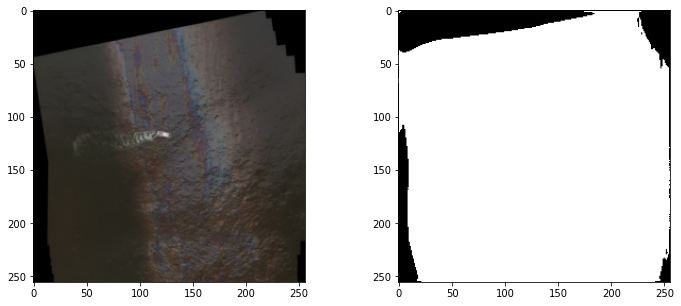

In [ ]:
with torch.no_grad():
    pred_mask = (unet_model(test_img_tens.to('cuda')) > 0.5).float()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(test_img_tens.squeeze().numpy().transpose(1, 2, 0))
ax[1].imshow(pred_mask.cpu().squeeze().numpy(), 'gray')
plt.show()